In [323]:
%matplotlib inline

import numpy as np
import pandas as pd

from sklearn import grid_search
from sklearn import metrics
from sklearn import cross_validation
from sklearn.externals import joblib

import xgboost as xgb

import matplotlib.pyplot as plt
import seaborn as sns

import operator
import itertools
import random

In [324]:
sns.set_context("paper")
sns.set(font_scale=1.5)
thesis_figsize = (12, 9)

In [325]:
FEATURES_DIRECTORY = "E:\\eaglesense\\data\\topviewkinect\\all"

In [326]:
FEATURES_TAG = "eval"

In [328]:
features_csv = "{root}/{tag}_features.csv".format(root=FEATURES_DIRECTORY, tag=FEATURES_TAG)
features_df = pd.read_csv(features_csv)

In [329]:
labels_csv = "{root}/{tag}_labels.csv".format(root=FEATURES_DIRECTORY, tag=FEATURES_TAG)
labels_df = pd.read_csv(labels_csv)

In [330]:
ACTIVITIES = ["Standing", "Sitting", "Pointing", "Phone", "Tablet", "Paper"]

In [331]:
NUM_ACTIVITIES = len(ACTIVITIES)

In [332]:
features_vector = features_df.drop(["subject"], axis=1)

(array([], dtype=float64), <a list of 0 Text yticklabel objects>)

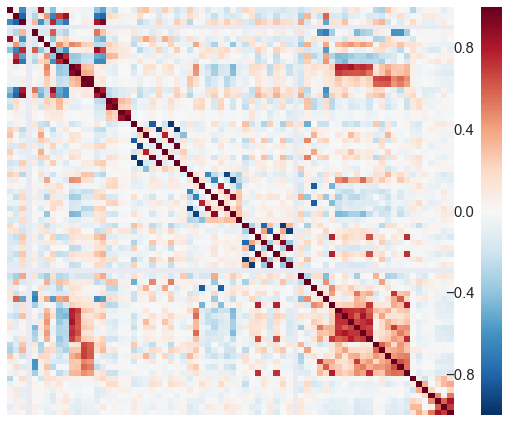

In [333]:
features_corr = features_vector.corr()
fig, ax = plt.subplots(figsize=(10,7.5))
x = sns.heatmap(features_corr, ax=ax, xticklabels=False, yticklabels=False)
sns.despine()
plt.yticks(rotation=0)

In [334]:
num_features = features_vector.shape[1]

In [335]:
output_vector = labels_df[["activity"]]

In [336]:
X = features_vector.values

In [337]:
y = output_vector.values

In [338]:
unique_subjects = features_df["subject"].unique()

# CROSS SUBJECT TEST 1 (50/50 Subjects)

In [339]:
features_df.shape

(77024, 73)

In [340]:
features_df.head()

,layer_area_0,layer_area_1,layer_area_2,layer_contours_0,layer_contours_1,layer_distance_0,layer_distance_1,layer_distance_2,layer_distance_3,layer_distance_4,...,interlayer_pos_16,interlayer_pos_17,extremities0,extreme_infrared_0,extreme_infrared_1,extreme_infrared_2,extreme_infrared_3,extreme_infrared_4,extreme_infrared_5,subject
0,0.297578,0.411765,0.290657,3.0,3.0,16.5529,26.6833,26.0192,26.6833,201.0,...,-26.0,-107.0,4.0,0.000000e+00,10.0,11.5,11.5,0.0,11.5,2001.0
1,0.310345,0.419238,0.270417,3.0,3.0,16.4012,26.4764,26.0192,26.4764,191.5,...,-26.0,-105.0,5.0,5.000000e-01,9.0,11.0,1.0,0.5,11.0,2001.0
2,0.333959,0.386492,0.279550,3.0,3.0,16.4012,26.2488,26.1725,26.2488,170.5,...,-25.0,-103.0,5.0,2.075076e-322,12.5,4.5,4.5,0.5,13.0,2001.0
3,0.348399,0.384181,0.267420,3.0,3.0,16.4012,26.4197,26.4764,26.4197,164.0,...,-25.0,-103.0,5.0,0.000000e+00,6.0,4.5,0.0,0.0,7.0,2001.0
4,0.356383,0.370567,0.273050,3.0,3.0,17.7200,27.4591,27.4591,27.4591,164.5,...,-26.0,-107.0,3.0,0.000000e+00,0.0,0.5,0.0,0.0,0.5,2001.0


In [341]:
crosssubject_1_X_train = np.array([], dtype=np.float64).reshape(0, num_features)
crosssubject_1_y_train = np.array([], dtype=np.int32).reshape(0, 1)

crosssubject_1_X_test = np.array([], dtype=np.float64).reshape(0, num_features)
crosssubject_1_y_test = np.array([], dtype=np.int32).reshape(0, 1)

for subject_id in unique_subjects:
    
    subject_features = features_df[features_df["subject"] == subject_id]
    subject_features = subject_features.drop(["subject"], axis=1)
    subject_labels = labels_df[labels_df["subject"] == subject_id]
    subject_labels = subject_labels[["activity"]]

    subject_X = subject_features.values
    subject_y = subject_labels.values
    
    if subject_id % 2 == 1:
        print(subject_id, "\tTrain")
        crosssubject_1_X_train = np.vstack([crosssubject_1_X_train, subject_X])
        crosssubject_1_y_train = np.vstack([crosssubject_1_y_train, subject_y])
    else:
        print(subject_id, "\tTest")
        crosssubject_1_X_test = np.vstack([crosssubject_1_X_test, subject_X])
        crosssubject_1_y_test = np.vstack([crosssubject_1_y_test, subject_y])

2001.0 	Train
2002.0 	Test
2003.0 	Train
2004.0 	Test
2005.0 	Train
2006.0 	Test
2007.0 	Train
2008.0 	Test
2009.0 	Train
2010.0 	Test
2011.0 	Train
2012.0 	Test


In [342]:
crosssubject_1_X_train.shape

(34945, 72)

In [343]:
crosssubject_1_X_test.shape

(42079, 72)

In [344]:
crosssubject_1_train_xgbmatrix = xgb.DMatrix(crosssubject_1_X_train, crosssubject_1_y_train)
crosssubject_1_test_xgbmatrix = xgb.DMatrix(crosssubject_1_X_test, crosssubject_1_y_test)
crosssubject_1_watchlist = [(crosssubject_1_train_xgbmatrix, "train"), (crosssubject_1_test_xgbmatrix, "eval")]

In [359]:
XGB_PARAM_FINAL = {}
XGB_PARAM_FINAL["eta"] = 0.3
XGB_PARAM_FINAL["gamma"] = 1
XGB_PARAM_FINAL["lambda"] = 1
XGB_PARAM_FINAL["alpha"] = 0
XGB_PARAM_FINAL["max_depth"] = 6
XGB_PARAM_FINAL["colsample_bytree"] = 0.5
XGB_PARAM_FINAL["colsample_bylevel"] = 0.5
XGB_PARAM_FINAL["subsample"] = 0.5
XGB_PARAM_FINAL["objective"] = "multi:softmax"
XGB_PARAM_FINAL["eval_metric"] = "merror"
XGB_PARAM_FINAL["num_class"] = len(ACTIVITIES)
XGB_PARAM_FINAL["silent"] = 0
XGB_NUM_ROUNDS = 200
XGB_EARLYSTOPPING_ROUNDS = 30

In [360]:
crosssubject_1_results = {}
cs_validation = xgb.train(params=XGB_PARAM_FINAL, dtrain=crosssubject_1_train_xgbmatrix, num_boost_round=XGB_NUM_ROUNDS,
                          evals=crosssubject_1_watchlist, evals_result=crosssubject_1_results,
                          early_stopping_rounds=XGB_EARLYSTOPPING_ROUNDS)

[0]	train-merror:0.053112	eval-merror:0.282588
Multiple eval metrics have been passed: 'eval-merror' will be used for early stopping.

Will train until eval-merror hasn't improved in 30 rounds.
[1]	train-merror:0.032909	eval-merror:0.212125
[2]	train-merror:0.02627	eval-merror:0.198294
[3]	train-merror:0.02212	eval-merror:0.174933
[4]	train-merror:0.020432	eval-merror:0.181896
[5]	train-merror:0.018744	eval-merror:0.171606
[6]	train-merror:0.017599	eval-merror:0.170726
[7]	train-merror:0.016254	eval-merror:0.173151
[8]	train-merror:0.014966	eval-merror:0.170726
[9]	train-merror:0.014108	eval-merror:0.163003
[10]	train-merror:0.012935	eval-merror:0.157157
[11]	train-merror:0.012191	eval-merror:0.153117
[12]	train-merror:0.011532	eval-merror:0.148007
[13]	train-merror:0.01076	eval-merror:0.140474
[14]	train-merror:0.010159	eval-merror:0.140735
[15]	train-merror:0.009443	eval-merror:0.134865
[16]	train-merror:0.008699	eval-merror:0.130445
[17]	train-merror:0.008356	eval-merror:0.129946
[1

# CROSS-SUBJECT 1 CLASSIFIER

In [361]:
crosssubject_1_booster = xgb.train(params=XGB_PARAM_FINAL, dtrain=crosssubject_1_train_xgbmatrix, 
                                   num_boost_round=cs_validation.best_iteration+1)

In [362]:
crosssubject_1_y_predicted = crosssubject_1_booster.predict(crosssubject_1_test_xgbmatrix)

In [363]:
crosssubject_1_accuracy = metrics.accuracy_score(crosssubject_1_y_test, crosssubject_1_y_predicted)
crosssubject_1_accuracy

0.90546353287863302

In [364]:
crosssubject_1_cm = metrics.confusion_matrix(crosssubject_1_y_test, crosssubject_1_y_predicted)
crosssubject_1_cm_normalized = crosssubject_1_cm.astype("float") / crosssubject_1_cm.sum(axis=1)[:, np.newaxis]
crosssubject_1_cm_normalized *= 100

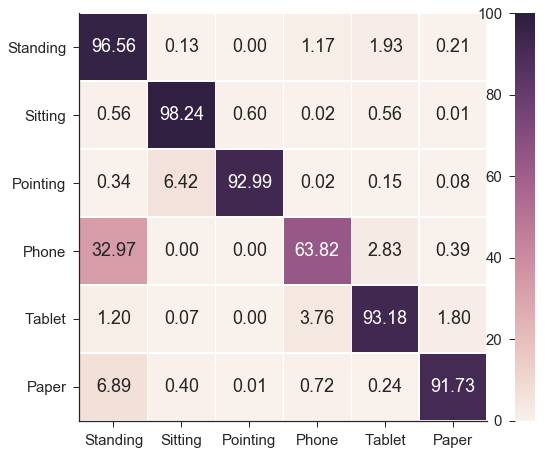

In [365]:
with sns.axes_style("ticks"):
    fig, ax = plt.subplots(figsize=(10, 7.5))
    sns.heatmap(data=crosssubject_1_cm_normalized, annot=True, fmt=".2f", linewidths=0.5, square=True,
                vmin=0, vmax=100, ax=ax, xticklabels=ACTIVITIES, yticklabels=ACTIVITIES)
    plt.yticks(rotation=0)
    sns.despine()

In [216]:
np.set_printoptions(formatter={'float': lambda x: "{:.2f}".format(x)})

for subject_id in unique_subjects:
    subject_features = features_df[features_df["subject"] == subject_id]
    subject_features = subject_features.drop(["subject"], axis=1)
    subject_labels = labels_df[labels_df["subject"] == subject_id]
    subject_labels = subject_labels[["activity"]]
    subject_X = subject_features.values
    subject_y = subject_labels.values

    subject_xgbmatrix = xgb.DMatrix(subject_X, subject_y)
    subject_y_predicted = crosssubject_1_booster.predict(subject_xgbmatrix)
    
    subject_accuracy = metrics.accuracy_score(subject_y, subject_y_predicted)
    subject_confusion_matrix = metrics.confusion_matrix(subject_y, subject_y_predicted)
    subject_confusion_matrix = subject_confusion_matrix.astype("float") / subject_confusion_matrix.sum(axis=1)[:, np.newaxis]
    subject_confusion_matrix *= 100
    
    print(subject_id, subject_accuracy)
    print(subject_confusion_matrix)

2001.0 0.998031848273
[[100.00 0.00 0.00 0.00 0.00 0.00]
 [0.00 99.93 0.07 0.00 0.00 0.00]
 [0.00 1.06 98.94 0.00 0.00 0.00]
 [0.49 0.00 0.00 99.51 0.00 0.00]
 [0.00 0.00 0.00 0.00 100.00 0.00]
 [0.00 0.00 0.00 0.00 0.00 100.00]]
2002.0 0.906400384986
[[96.19 0.61 0.00 0.76 1.98 0.46]
 [0.71 99.22 0.06 0.00 0.00 0.00]
 [2.84 10.28 84.75 0.00 1.77 0.35]
 [11.37 0.00 0.00 58.60 25.95 4.08]
 [1.41 0.12 0.00 0.00 84.29 14.19]
 [4.78 1.66 0.00 0.00 0.42 93.14]]
2003.0 0.99919175591
[[99.87 0.00 0.00 0.00 0.13 0.00]
 [0.00 100.00 0.00 0.00 0.00 0.00]
 [0.00 0.45 99.55 0.00 0.00 0.00]
 [0.00 0.00 0.00 100.00 0.00 0.00]
 [0.13 0.00 0.00 0.00 99.74 0.13]
 [0.00 0.00 0.00 0.00 0.00 100.00]]
2004.0 0.971540726202
[[92.64 0.12 0.00 4.83 2.42 0.00]
 [0.08 97.86 0.08 0.00 1.98 0.00]
 [0.00 3.57 96.26 0.00 0.17 0.00]
 [0.13 0.00 0.00 99.22 0.65 0.00]
 [1.15 0.00 0.00 0.35 98.50 0.00]
 [1.76 0.00 0.00 0.00 0.00 98.24]]
2005.0 0.999640740075
[[99.90 0.00 0.00 0.10 0.00 0.00]
 [0.00 100.00 0.00 0.00 0.0

In [217]:
feature_importance = crosssubject_1_booster.get_fscore()

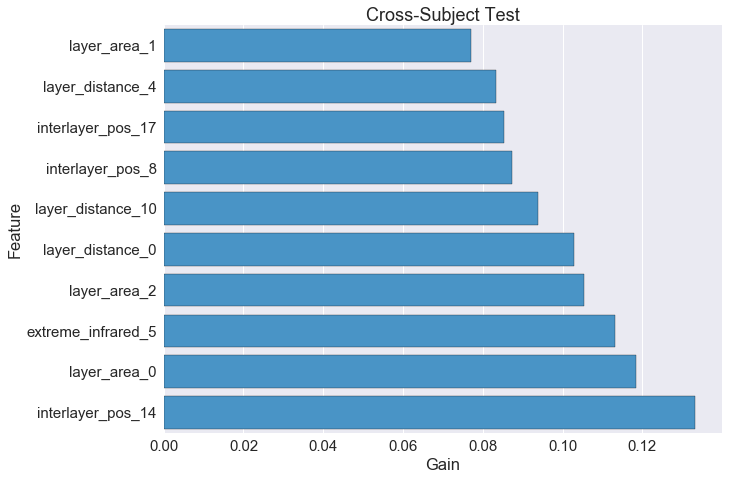

In [218]:
# Create feature importance dataframe
features_importance_formatted = dict()
for feature_idx, feature_name in enumerate(features_vector.columns):
    old_key = "f{}".format(feature_idx)
    if old_key not in feature_importance:
        continue
    new_key = feature_name
    features_importance_formatted[new_key] = feature_importance[old_key]

features_importance_formatted = sorted(features_importance_formatted.items(), key=operator.itemgetter(1))
features_importance_top10 = features_importance_formatted[-10:]
features_importance_df = pd.DataFrame(features_importance_top10, columns=["feature", "gain"])
features_importance_df["gain"] = features_importance_df["gain"] / features_importance_df["gain"].sum()

# Plot
fig, ax = plt.subplots(figsize=(10,7.5))
sns.barplot(x="gain", y="feature", data=features_importance_df, label="Total", color="#3498db", ax=ax)
sns.despine()
ax.set_xlabel("Gain")
ax.set_ylabel("Feature")
ax.set_title("Cross-Subject Test")

In [277]:
features_importance_formatted

[('layer_distance_8', 3),
 ('layer_distance_13', 5),
 ('layer_distance_7', 6),
 ('extremities0', 7),
 ('layer_distance_14', 8),
 ('intralayer_pos_23', 19),
 ('intralayer_pos_0', 19),
 ('layer_distance_5', 19),
 ('layer_distance_6', 24),
 ('intralayer_pos_5', 29),
 ('intralayer_pos_3', 30),
 ('layer_distance_11', 30),
 ('intralayer_pos_20', 32),
 ('intralayer_pos_8', 33),
 ('layer_distance_12', 34),
 ('extreme_infrared_1', 43),
 ('intralayer_pos_19', 44),
 ('intralayer_pos_22', 46),
 ('intralayer_pos_17', 48),
 ('intralayer_pos_21', 48),
 ('intralayer_pos_6', 50),
 ('extreme_infrared_2', 50),
 ('intralayer_pos_2', 51),
 ('intralayer_pos_12', 51),
 ('intralayer_pos_9', 53),
 ('intralayer_pos_25', 54),
 ('intralayer_pos_24', 55),
 ('intralayer_pos_1', 55),
 ('extreme_infrared_0', 56),
 ('interlayer_pos_9', 56),
 ('interlayer_pos_15', 57),
 ('intralayer_pos_18', 58),
 ('interlayer_pos_0', 59),
 ('interlayer_pos_6', 61),
 ('interlayer_pos_12', 63),
 ('intralayer_pos_15', 64),
 ('interlayer_

# DEMOS

In [4]:
p1_features_csv = "{root}/{tag}_features.csv".format(root=FEATURES_DIRECTORY, tag="p1")
p1_features_df = pd.read_csv(p1_features_csv)
p1_labels_csv = "{root}/{tag}_labels.csv".format(root=FEATURES_DIRECTORY, tag="p1")
p1_labels_df = pd.read_csv(p1_labels_csv)

In [5]:
all_features_csv = "{root}/{tag}_features.csv".format(root=FEATURES_DIRECTORY, tag="all")
all_features_df = pd.read_csv(all_features_csv)
all_labels_csv = "{root}/{tag}_labels.csv".format(root=FEATURES_DIRECTORY, tag="all")
all_labels_df = pd.read_csv(all_labels_csv)

In [6]:
eval_features_csv = "{root}/{tag}_features.csv".format(root=FEATURES_DIRECTORY, tag="eval")
eval_features_df = pd.read_csv(eval_features_csv)
eval_labels_csv = "{root}/{tag}_labels.csv".format(root=FEATURES_DIRECTORY, tag="eval")
eval_labels_df = pd.read_csv(eval_labels_csv)

In [7]:
# standing and tablet only

p1_features = p1_features_df.drop(["subject"], axis=1)
p1_labels = p1_labels_df[["activity"]]
p1_standingtablet_series = p1_labels["activity"].isin([0, 4])
p1_standingtablet_features = p1_features.loc[p1_standingtablet_series]
p1_standingtablet_labels = p1_labels.loc[p1_standingtablet_series]
p1_X = p1_standingtablet_features.values
p1_y = p1_standingtablet_labels.values

all_features = all_features_df.drop(["subject"], axis=1)
all_labels = all_labels_df[["activity"]]
all_standingtablet_series = all_labels["activity"].isin([0, 4])
all_standingtablet_features = all_features.loc[all_standingtablet_series]
all_standingtablet_labels = all_labels.loc[all_standingtablet_series]
all_X = all_standingtablet_features.values
all_y = all_standingtablet_labels.values

eval_features = eval_features_df.drop(["subject"], axis=1)
eval_labels = eval_labels_df[["activity"]]
eval_standingtablet_series = eval_labels["activity"].isin([0, 4])
eval_standingtablet_features = eval_features.loc[eval_standingtablet_series]
eval_standingtablet_labels = eval_labels.loc[eval_standingtablet_series]
eval_X = eval_standingtablet_features.values
eval_y = eval_standingtablet_labels.values

In [8]:
p1_standingtablet_features.shape

(1930, 77)

In [9]:
p1_standingtablet_labels.shape

(1930, 1)

In [10]:
all_standingtablet_features.shape

(27996, 77)

In [11]:
all_standingtablet_labels.shape

(27996, 1)

In [12]:
eval_standingtablet_features.shape

(26066, 77)

In [14]:
eval_standingtablet_labels.shape

(26066, 1)

In [17]:
XGB_PARAM_FINAL = {}
XGB_PARAM_FINAL["eta"] = 0.3
XGB_PARAM_FINAL["gamma"] = 1
XGB_PARAM_FINAL["lambda"] = 2
XGB_PARAM_FINAL["alpha"] = 1
XGB_PARAM_FINAL["max_depth"] = 7
XGB_PARAM_FINAL["colsample_bytree"] = 0.5
XGB_PARAM_FINAL["colsample_bylevel"] = 0.5
XGB_PARAM_FINAL["subsample"] = 0.5
XGB_PARAM_FINAL["objective"] = "multi:softmax"
XGB_PARAM_FINAL["eval_metric"] = "merror"
XGB_PARAM_FINAL["num_class"] = len(ACTIVITIES)
XGB_PARAM_FINAL["silent"] = 0

XGB_NUM_ROUNDS = 200
XGB_EARLYSTOPPING_ROUNDS = 30

In [18]:
standingtablet_train_xgbmatrix = xgb.DMatrix(all_X, all_y)
standingtablet_test_xgbmatrix = xgb.DMatrix(p1_X, p1_y)
standingtablet_watchlist = [(standingtablet_train_xgbmatrix, "train"), (standingtablet_test_xgbmatrix, "eval")]

In [19]:
standingtablet_results = {}
standingtablet_validation = xgb.train(params=XGB_PARAM_FINAL, dtrain=standingtablet_train_xgbmatrix, num_boost_round=XGB_NUM_ROUNDS,
                          evals=standingtablet_watchlist, evals_result=standingtablet_results,
                          early_stopping_rounds=XGB_EARLYSTOPPING_ROUNDS)

[0]	train-merror:0.030397	eval-merror:0.118653
Multiple eval metrics have been passed: 'eval-merror' will be used for early stopping.

Will train until eval-merror hasn't improved in 30 rounds.
[1]	train-merror:0.025182	eval-merror:0.106736
[2]	train-merror:0.024289	eval-merror:0.103627
[3]	train-merror:0.02186	eval-merror:0.094301
[4]	train-merror:0.020324	eval-merror:0.089637
[5]	train-merror:0.019146	eval-merror:0.084456
[6]	train-merror:0.017931	eval-merror:0.080829
[7]	train-merror:0.016931	eval-merror:0.076684
[8]	train-merror:0.015931	eval-merror:0.073057
[9]	train-merror:0.015038	eval-merror:0.070466
[10]	train-merror:0.014645	eval-merror:0.065803
[11]	train-merror:0.014002	eval-merror:0.064249
[12]	train-merror:0.012966	eval-merror:0.060622
[13]	train-merror:0.011645	eval-merror:0.054922
[14]	train-merror:0.010752	eval-merror:0.050259
[15]	train-merror:0.010144	eval-merror:0.047668
[16]	train-merror:0.009144	eval-merror:0.043523
[17]	train-merror:0.008787	eval-merror:0.041969


In [20]:
standingtablet_booster = xgb.train(params=XGB_PARAM_FINAL, dtrain=standingtablet_train_xgbmatrix, num_boost_round=28)

In [21]:
standingtablet_booster.save_model("standingtablet-xgboost.model")

In [22]:
standingtablet_booster = xgb.Booster(model_file="standingtablet-xgboost.model")

In [23]:
y_predicted = standingtablet_booster.predict(standingtablet_test_xgbmatrix)
accuracy = metrics.accuracy_score(p1_y, y_predicted)
accuracy

0.97823834196891191